# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

##### Notebook settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

##### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight

import keras
from keras.layers import Input, Conv2D, Add, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, Flatten, ZeroPadding2D
from keras import layers
from tensorflow.keras.applications import ResNet50V2, EfficientNetB4
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

import os, shutil, random, cv2
from shutil import copyfile
from distutils.dir_util import copy_tree
from tqdm import tqdm

##### Download dataset

###### *Chest X-Ray Images (Pneumonia)*  
[Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
[Paper](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)
[Data](https://data.mendeley.com/datasets/rscbjbr9sj/2)


In [3]:
# problem: also 'small' part of the normal images in the used covid dataset
if not os.path.exists('chest_xray'):
    !wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded -O ChestXRay2017.zip
    !unzip -q ChestXRay2017.zip
    !rm ChestXRay2017.zip
    !rm -r __MACOSX
    !rm chest_xray/train/PNEUMONIA/.DS_Store

--2021-04-29 13:32:31--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2021-04-29 13:32:32--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.28.120
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.28.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [applicat

##### Define constants

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

## Data


### Create dataset

In [5]:
savepath = 'data'

## dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# path to normal 
normal_imgpaths = ['chest_xray/train/NORMAL', 'chest_xray/test/NORMAL']

# path to pneumonia 
pneumonia_imgpaths = ['chest_xray/train/PNEUMONIA', 'chest_xray/test/PNEUMONIA']

In [6]:
# stats
normal_cnt = sum([len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]) for path in normal_imgpaths])
pneumonia_cnt = sum([len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]) for path in pneumonia_imgpaths])

class_count = {'normal': normal_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + pneumonia_cnt)

Class count:  {'normal': 1583, 'pneumonia': 4273}
Total images:  5856


### Load dataset

###### Retrieve filenames (paths) and labels

In [7]:
def get_data(paths, label_encoding):
    normal_imgpaths, pneumonia_imgpaths = paths
    filenames = []
    y_labels = []

    # nomal
    nomal_images = []
    for nomal_imgpath in normal_imgpaths:
        nomal_images.extend([nomal_imgpath + '/' + name for name in os.listdir(nomal_imgpath) if os.path.isfile(os.path.join(nomal_imgpath, name))])
    random.shuffle(nomal_images)
    nomal_images = nomal_images[:int(len(nomal_images))]
    filenames.extend(nomal_images)
    y_labels.extend([label_encoding.index('normal') for img in nomal_images])

    # pneumonia
    pneumonia_images = []
    for pneumonia_imgpath in pneumonia_imgpaths:
        pneumonia_images.extend([pneumonia_imgpath + '/' + name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])
    random.shuffle(pneumonia_images)
    pneumonia_images = pneumonia_images[:int(IMBALANCE_RATIO*len(nomal_images))]
    filenames.extend(pneumonia_images)
    y_labels.extend([label_encoding.index('pneumonia') for img in pneumonia_images])

    return np.array(filenames), np.array(y_labels)

In [8]:
datapaths = [normal_imgpaths, pneumonia_imgpaths]
label_encoding = ['normal', 'pneumonia'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [9]:
# create train-val-test split
x_train, x_val, y_train, y_val = train_test_split(files, labels, test_size=2*SPLIT, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=random_state)

In [10]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'pneumonia': np.count_nonzero(y == 1)}

In [11]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set:   ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 1093, 'pneumonia': 1676}
val set:    {'normal': 256, 'pneumonia': 338}
test set:   {'normal': 234, 'pneumonia': 360}


###### Create tensors

In [12]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [13]:
def get_img(x, y):
    file_path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [14]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

In [15]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_ds).numpy()
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 2769, Val: 594, Test: 594


### Prepare for training

###### Define preprocessing

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

###### Define data augmentation

In [17]:
# implemented as keras layers below but kept for quick overview
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=(0.85, 1.15), # randomly zoom image 
        brightness_range=(0.9, 1.1), # randomly shift brightness
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='constant',   # constant filling of points outside boundaries of input
        cval=0.,)   # fill with zeros, see fill_mode

In [18]:
class RandomBrightness(layers.Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [20]:
def prepare_training(ds, shuffle=False, repeat=False, augment=False, cache=True, shuffle_buffer_size=1000):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # repeat training set forever
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)

    # batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # fetches batches in the background while training the model
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_batched = prepare_training(train_ds, shuffle=True, repeat=True, augment=True, cache='cache')
val_batched = prepare_training(val_ds)
test_batched = prepare_training(test_ds)

### Visualization

###### Distribution of labels in the sets

In [22]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

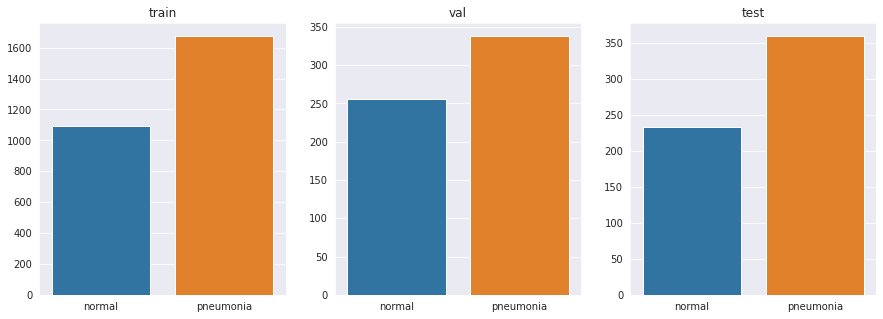

In [23]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [24]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("PNEUMONIA")
        plt.axis("off")

In [25]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


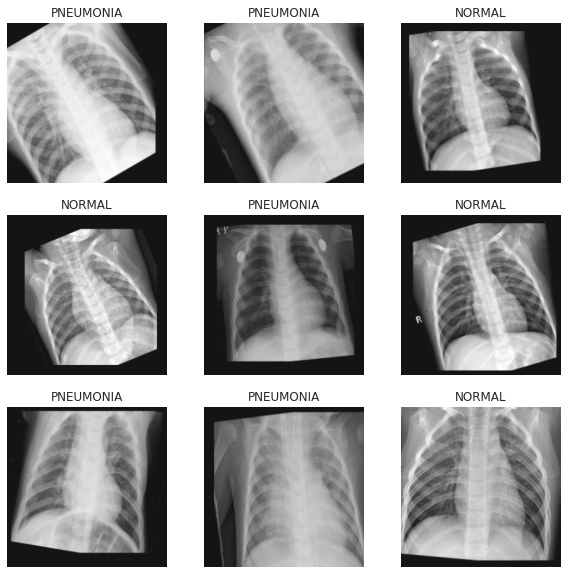

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())
print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for pneumonia: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	1.27
Weight for pneumonia: 	0.83


### Learning rate decay

In [28]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

### Early stopping


In [29]:
# checkpoint = ModelCheckpoint("x-covid.h5", monitor=monitor='val_loss', save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## DP-Net - CNN Archecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
[[Paper 2](https://openreview.net/forum?id=rJg851rYwH)]
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [32]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ])
    return dpnet

In [33]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(
    optimizer=Adam(lr=1e-3), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

In [34]:
dpnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)             

### Training

In [35]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
86/86 [==============================] - 77s 617ms/step - loss: 0.5176 - accuracy: 0.7336 - precision: 0.8421 - recall: 0.6882 - val_loss: 1.6126 - val_accuracy: 0.5712 - val_precision: 0.5712 - val_recall: 1.0000
Epoch 2/20
86/86 [==============================] - 39s 457ms/step - loss: 0.4382 - accuracy: 0.8022 - precision: 0.8829 - recall: 0.7710 - val_loss: 2.6313 - val_accuracy: 0.5712 - val_precision: 0.5712 - val_recall: 1.0000
Epoch 3/20
86/86 [==============================] - 39s 460ms/step - loss: 0.3491 - accuracy: 0.8546 - precision: 0.9235 - recall: 0.8274 - val_loss: 1.1455 - val_accuracy: 0.5729 - val_precision: 0.5724 - val_recall: 0.9970
Epoch 4/20
86/86 [==============================] - 41s 479ms/step - loss: 0.3497 - accuracy: 0.8524 - precision: 0.9285 - recall: 0.8231 - val_loss: 1.6936 - val_accuracy: 0.4601 - val_precision: 1.0000 - val_recall: 0.0547
Epoch 5/20
86/86 [==============================] - 43s 511ms/step - loss: 0.3710 - accuracy: 0.8379

### Evaluation

###### Visualize performance

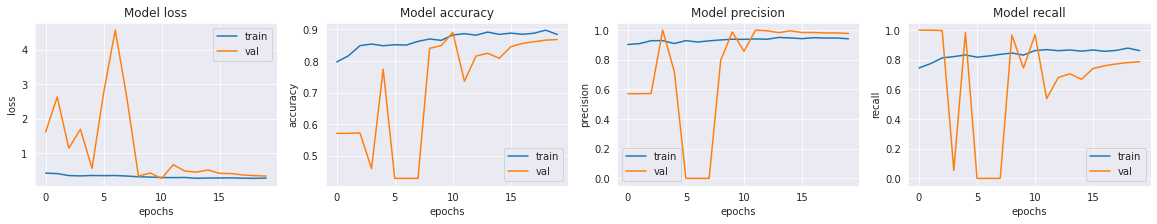

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].plot(history_dpnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [37]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

19/19 [==============================] - 4s 224ms/step - loss: 0.3351 - accuracy: 0.8653 - precision: 0.9605 - recall: 0.8111
Loss of the model is -  0.3351454734802246
Accuracy of the model is -  86.53198480606079 %
Precision of the model is -  0.9605262875556946
Recall of the model is -  0.8111110925674438


###### Save for transfer learning

In [38]:
# save model
# attach the preprocessing layers!
#resnet18.save("resnet18_public.h5")
# load model
#resnet18 = keras.models.load_model("resnet18_public.h5")

# save weights
dpnet.save_weights('dpnet_tanh_public_weights.h5')
# load weights
#resnet18.load_weights('resnet18_tanh_public_weights.h5') #, by_name=True)